In [100]:
# import packages

from gpxcsv import gpxtolist
import pandas as pd
import geopandas as gpd
from datetime import datetime
import pytz
from timezonefinder import TimezoneFinder
import matplotlib.pyplot as plt
import numpy as np

**QUESTION 1**

In [101]:
def create_geopandas_df(filename):
    """
    function takes filename as input and converts the data into a Geodataframe.
    It converts time parameter to datetime object in its own timezone using lon & lat
    Function creates a geometry column in UTM coordinates using the lon and lat fields.
    
    Parameters:
    - filename: str, the name of the GPX file
    
    Returns:
    - geo_df_utm: GeoDataFrame, the converted GPX data with UTM coordinates
    """
    
    # convert all times to datetime objects in their own timezone using lon and lat
    
    # using old code from group assignment / class notes
    gpx_list = gpxtolist(filename)
    gpd_df = pd.DataFrame(gpx_list)
    gpd_df.time = pd.to_datetime(gpd_df["time"], format="%Y-%m-%dT%H:%M:%SZ")
    gmt_zone = pytz.timezone("GMT")
    
    try:
        gpd_df["time"] = gpd_df["time"].dt.tz_localize(gmt_zone)
    except:
        print("Already timezone aware")
        
    # using timezonefinder docs
    tf = TimezoneFinder()
    tz = tf.timezone_at(lng=gpd_df["lon"].iloc[0], lat=gpd_df["lat"].iloc[0])    
        
    local_zone = pytz.timezone(tz)
    gpd_df["time"] = gpd_df["time"].dt.tz_convert(local_zone)
    
    # use lon and lat fields to create geometry column in UTM coordinates
    
    # using old code from group assignment / class notes
    
    geo_df = gpd.GeoDataFrame(gpd_df,geometry=gpd.points_from_xy(gpd_df["lon"], gpd_df["lat"], gpd_df["ele"]),)

    geo_df = geo_df.set_crs("epsg:4326")

    geo_df_utm = geo_df.to_crs(epsg=32615)
    
    return geo_df_utm

**QUESTION 2**

In [102]:
def compute_pace(geo_df, smoothing_param):
    """
    Compute the pace for each point in a GeoDataFrame and apply smoothing using a moving    average.

    Parameters:
    - geo_df (gpd.GeoDataFrame): The input GeoDataFrame containing the GPS data.
    - smoothing_param (int): The parameter for smoothing, should be an odd integer.

    Returns:
    - np.ndarray: The array of smoothed pace values.
    """
    
    # Initialize arrays for pace and smoothed pace
    pace = np.zeros(len(geo_df))
    smoothed_pace = np.zeros(len(geo_df))

    # using old code from group assignment / class notes
    
    # Calculate pace for each point
    for i in range(1, len(geo_df)):
        time_diff = (geo_df['time'].iloc[i] - geo_df['time'].iloc[i - 1]).total_seconds()
        distance = geo_df['geometry'].iloc[i].distance(geo_df['geometry'].iloc[i - 1])
        if distance == 0:
            pace[i] = float("inf")
        else:
            pace[i] = time_diff / distance * (1609.34/60) # convert to min/mi (Googled the #)

    # Apply smoothing using a moving average
    # ChatGPT: "How do I use a smoothing parameter (that defines the size of a smoothing kernel) to smooth the data in a numpy array" (to be honest I couldn't find the class notes for this part)
    half_kernel = smoothing_param // 2
    for i in range(half_kernel, len(geo_df) - half_kernel):
        smoothed_pace[i] = np.mean(pace[i - half_kernel:i + half_kernel + 1])

    return smoothed_pace

In [103]:
def plot_smoothing(geo_df,smoothing_params):
    """
    Creates a graph to show the difference in pace between 3 different smoothing parameters in a geodataframe

    Parameters:
    - geo_df (gpd.GeoDataFrame): The input GeoDataFrame containing the GPS data.
    - smoothing_params (int list): List containing exactly 3 parameters for smoothing, should be odd integers.

    Returns:
    - matplotlib graph
    """
    
    # referencing the case study and Datacamps on matplotlib
    
    plt.figure(figsize=(12, 6))

    for smoothing_param in smoothing_params:
        smoothed_pace = compute_pace(geo_df, smoothing_param)
        plt.plot(geo_df['time'], smoothed_pace, label=f'Smoothing = {smoothing_param}')

    plt.xlabel("Time")
    plt.ylabel("Pace")
    plt.title("Pace as a Function of Time")
    plt.legend()
    plt.show()

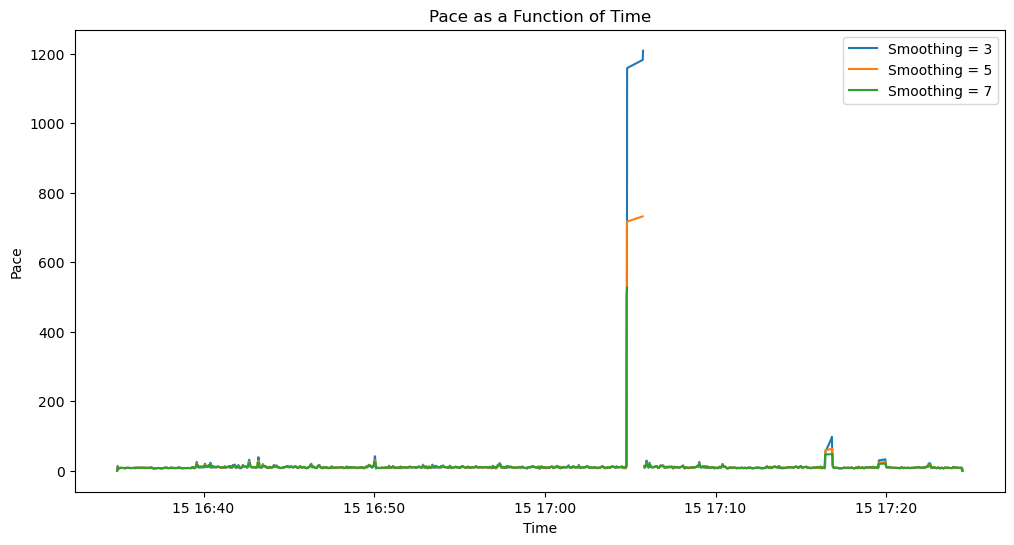

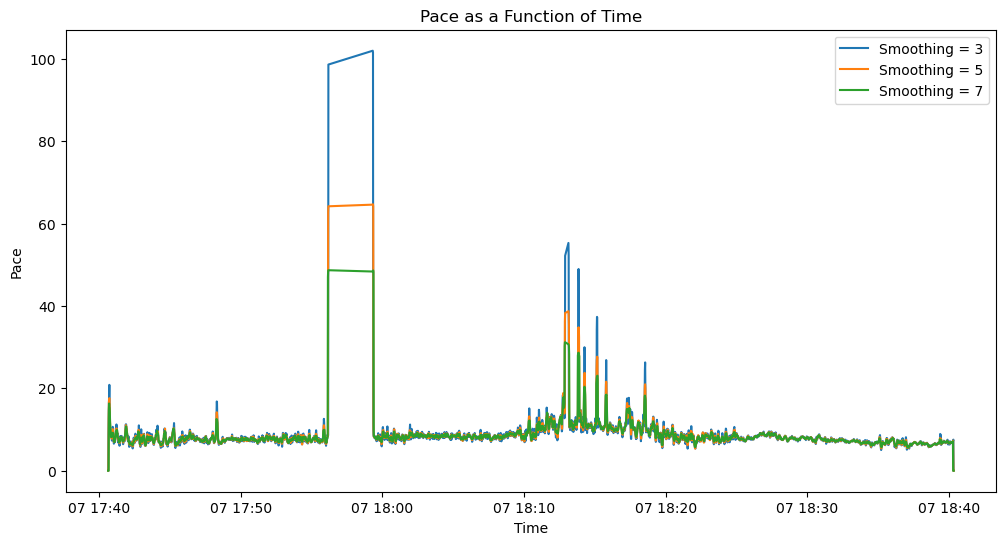

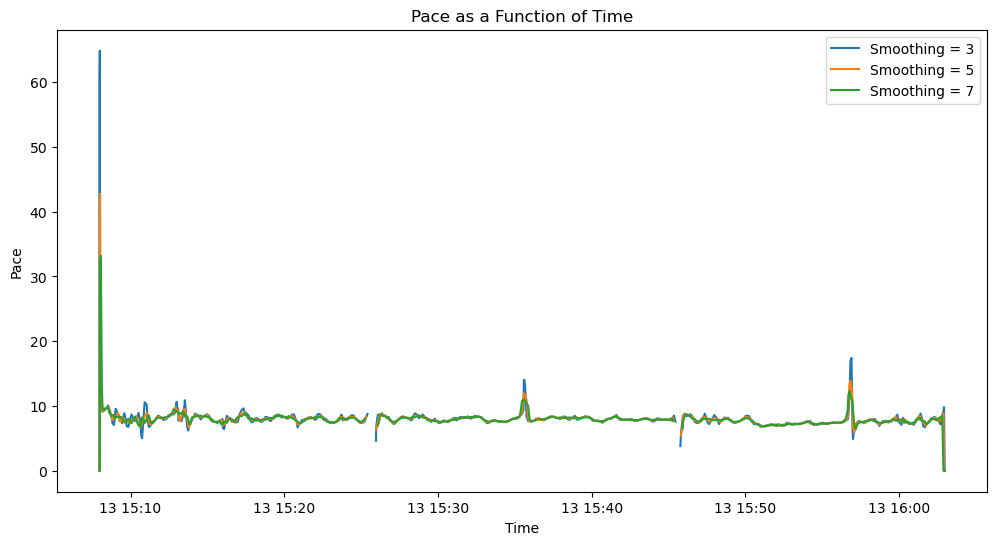

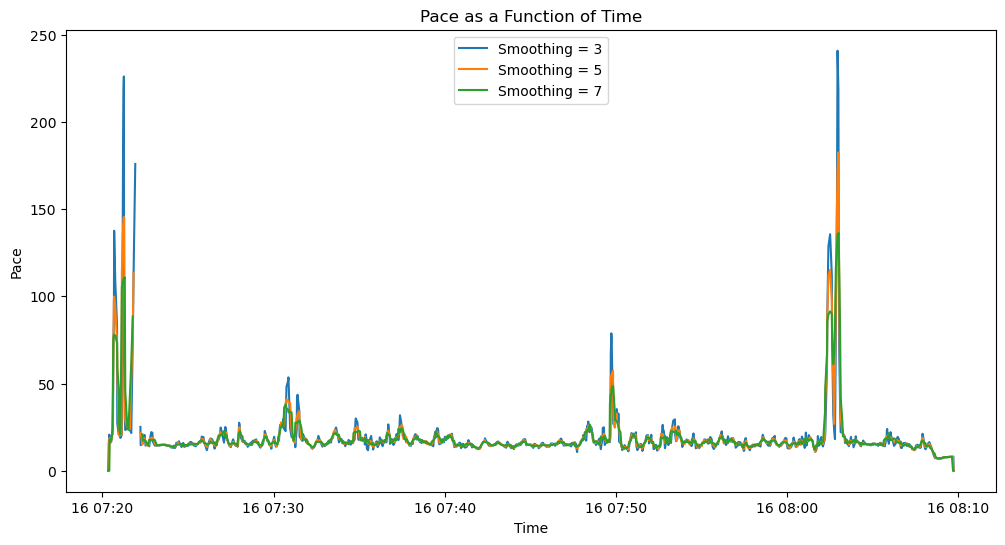

In [104]:
files_list = ["Track 1.gpx","Track 2.gpx","Track 3.gpx","Track 4.gpx"]

for file in files_list:
    df = create_geopandas_df(file)
    plot_smoothing(df,[3,5,7])

**QUESTION 3**

In [111]:
def classify_epoch(geo_df, smoothing_params):
    """
    Classifies each epoch as running, walking, not moving, or paused.

    Parameters:
    - geo_df (gpd.GeoDataFrame): The input GeoDataFrame containing the GPS data.
    - smoothing_params (int list): List containing exactly 3 parameters for smoothing, should be odd integers.

    Returns:
    - Pandas DataFrame containing information on the amount of time spent running, walking, not moving, and not recording at 3 different smoothing levels.
    """

    # most of the code came from class notes and past functions, however I also pasted the old function into ChatGPT the way it was and got ChatGPT to do some cleanup in terms of efficiency and readability
    
    classified_epochs_df = pd.DataFrame()

    # go through each of the three smoothing params
    for smoothing_param in smoothing_params:
        smoothed_pace = compute_pace(geo_df, smoothing_param)

        # initialize variables for classification
        running_time = 0
        walking_time = 0
        not_moving_time = 0
        paused_time = 0
        last_time = None

        # loop through geo_df to classify each epoch and add time_diff to each category
        for i in range(len(geo_df)):
            time_diff = (geo_df['time'].iloc[i] - last_time).total_seconds() if last_time else 0

            if time_diff > 15:
                classification = "paused"
                paused_time += time_diff
            else:
                pace = smoothed_pace[i]
                if pace >= 60:
                    classification = "not moving"
                    not_moving_time += time_diff
                elif pace >= 15:
                    classification = "walking"
                    walking_time += time_diff
                else:
                    classification = "running"
                    running_time += time_diff

            last_time = geo_df['time'].iloc[i]
            geo_df.loc[i, 'classification'] = classification

        result_dict = {
            "Smoothing Level": smoothing_param,
            "Running Time (seconds)": running_time,
            "Walking Time (seconds)": walking_time,
            "Not Moving Time (seconds)": not_moving_time,
            "Paused Recording Time (seconds)": paused_time
        }

        result_df = pd.DataFrame([result_dict])
        classified_epochs_df = pd.concat([classified_epochs_df, result_df], ignore_index=True)

    return classified_epochs_df


In [112]:
files_list = ["Track 1.gpx","Track 2.gpx","Track 3.gpx","Track 4.gpx"]

for file in files_list:
    df = create_geopandas_df(file)
    print(classify_epoch(df,[1,5,9]))

   Smoothing Level  Running Time (seconds)  Walking Time (seconds)  \
0                1                  2739.0                   127.0   
1                5                  2768.0                    96.0   
2                9                  2767.0                    95.0   

   Not Moving Time (seconds)  Paused Recording Time (seconds)  
0                        7.0                             99.0  
1                        9.0                             99.0  
2                       11.0                             99.0  
   Smoothing Level  Running Time (seconds)  Walking Time (seconds)  \
0                1                  3331.0                    47.0   
1                5                  3327.0                    63.0   
2                9                  3314.0                    80.0   

   Not Moving Time (seconds)  Paused Recording Time (seconds)  
0                       16.0                            188.0  
1                        4.0                          

**QUESTION 4**

In [116]:
def compute_fastest_interval(geo_df, interval):
    """
    Computes the interval with the fastest average pace during a run based on distance traveled.

    Parameters:
    - geo_df (gpd.GeoDataFrame): The input GeoDataFrame containing GPS data.
    - interval (float): The specified interval (in miles) for which to find the fastest average pace.

    Returns:
    - Tuple (float, float, float): The fastest average pace (in minutes per mile), the start index, and the end index of the interval.
    """

    # Convert interval to meters
    interval_meters = interval * 1609.34

    fastest_pace = float('inf')  # Initialize with positive infinity

    # nested for loops (can be optimized later), outer for the "start" of the interval, inner for the "end" of the interval

    for outer in range(1, len(geo_df)):
        
        distance_accumulated = 0

        for inner in range(outer, len(geo_df)):
            
            # Calculate the distance traveled in this epoch
            epoch_distance = geo_df['geometry'].iloc[inner].distance(geo_df['geometry'].iloc[inner-1])

            distance_accumulated += epoch_distance
            
            if distance_accumulated >= interval_meters:
                time_diff = (geo_df['time'].iloc[inner] - geo_df['time'].iloc[outer]).total_seconds()
                pace_slice =  time_diff / distance_accumulated
                
                if pace_slice < fastest_pace:
                    fastest_pace = pace_slice
                    start_index = outer
                    end_index = inner

                inner = len(geo_df) - 1

                    
    return (fastest_pace * 26.8224, start_index, end_index)


In [117]:
files_list = ["Track 1.gpx","Track 2.gpx","Track 3.gpx","Track 4.gpx"]
intervals = [1,.5,.25,0.0621371]

for interval in intervals:
    df = create_geopandas_df(file)
    print(compute_fastest_interval(df,interval))
    print()

(14.248120630260482, 688, 965)

(12.11765479647403, 858, 965)

(9.367294166718327, 923, 965)

(5.761989828674466, 950, 957)



**QUESTION 5**

In [119]:
def compute_efficiency_score(df):

    """
    Computes an efficiency score using heart rate, elevation and pace.

    Parameters:
    - df (gpd.GeoDataFrame): The input GeoDataFrame containing GPS data.

    Returns:
    - numpy array (float) with an efficiency score for every row in the dataframe
    """

    # initialize efficiency score array
    efficiency_score = np.zeros(len(df))

    # compute pace
    pace = compute_pace(df, 1)

    for i in range(1,len(df)):

        ele_change = df["ele"].iloc[i] - df["ele"].iloc[i-1]

        """
        
        Basic algorithm for effiency score: elevation change raises score if positive or negative - changes in elevation increase run difficulty,
        lower heart rate and lower pace raise score since those are associated with a more "successful" run.

        Higher efficiency score = better run

        """

        efficiency_score[i] = (100 + abs(ele_change)) / (df["hr"].iloc[i] * pace[i])


    return efficiency_score

In [120]:
def map_efficiency_score(df):
    
    """
    Creates a graph to show the changing efficiency score for a run

    Parameters:
    - df_list (gpd.GeoDataFrame): List of GeoDataFrames containing the GPS data.

    Returns:
    - matplotlib graph
    """
    
    plt.figure(figsize=(12, 6))

    efficiency_score = compute_efficiency_score(df)
    average_efficiency_score = efficiency_score.mean()

    plt.plot(df['time'], efficiency_score)

    # Add an average efficiency score line in red
    plt.axhline(y=average_efficiency_score, color='red', linestyle='--', label="Average Efficiency Score")

    plt.xlabel("Time")
    plt.ylabel("Effiency Score")
    plt.title("Efficiency Score as a Function of Time")
    plt.legend()
    plt.show()

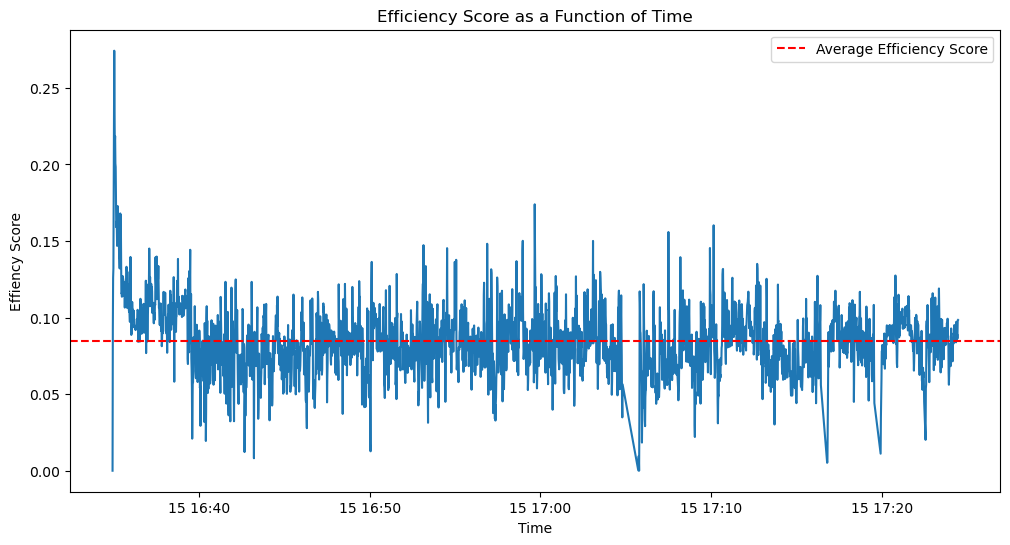

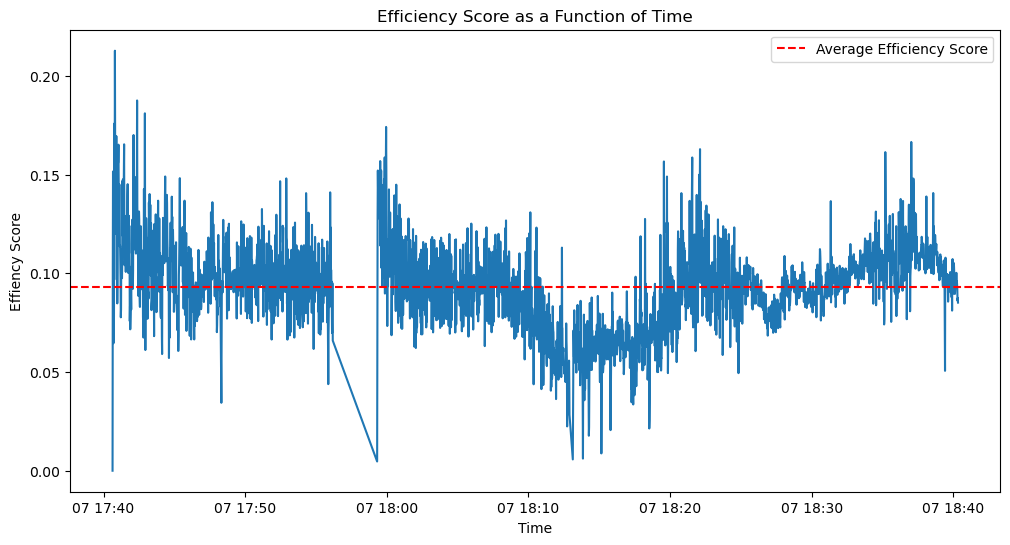

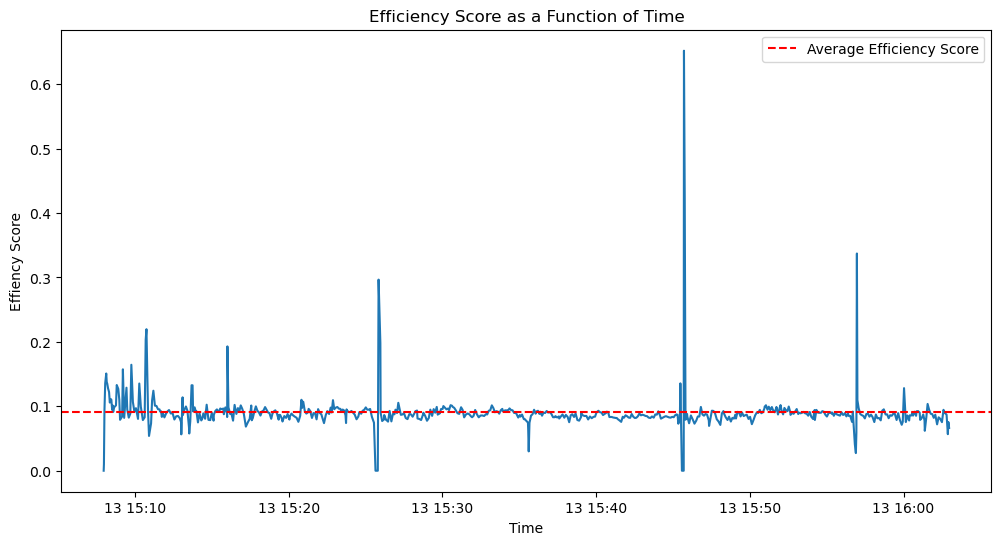

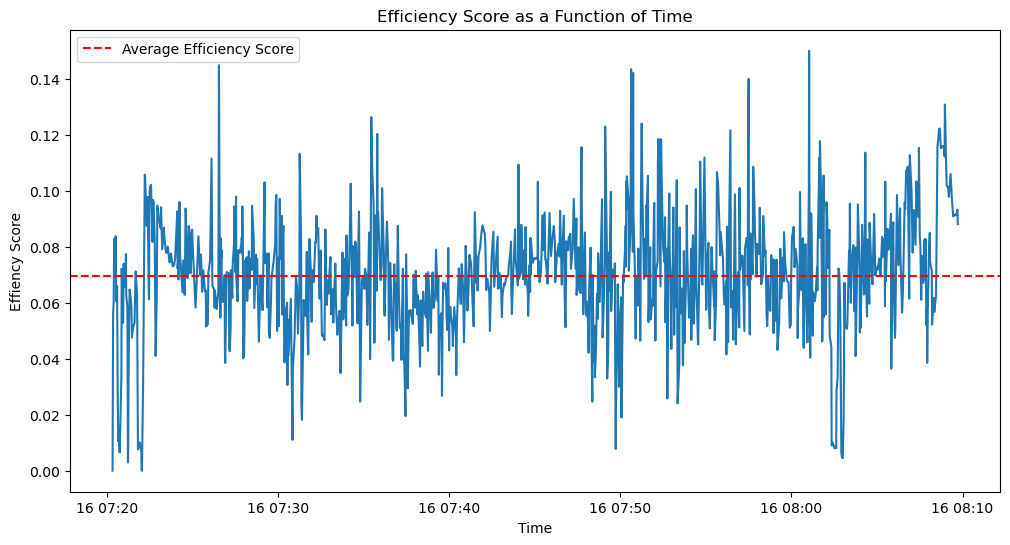

'"\n\nWe can see here that Track 4 hovers around a .07 efficiency score, \ncompared to the other graphs where the efficiency score ranges from .8 to .1,\nshowing that Track 4 required the most effort and was, on average, a less efficient run.\n\nIt\'s also very clear from these graphs where efficiency rose and fell with some graphs\'\nefficiency levels going up and down and with others staying relatively the same throughout.\n\n'

In [121]:
files_list = ["Track 1.gpx","Track 2.gpx","Track 3.gpx","Track 4.gpx"]

for file in files_list: 
    df = create_geopandas_df(file)
    map_efficiency_score(df)


""""

We can see here that Track 4 hovers around a .07 efficiency score, 
compared to the other graphs where the efficiency score ranges from .8 to .1,
showing that Track 4 required the most effort and was, on average, a less efficient run.

It's also very clear from these graphs where efficiency rose and fell with some graphs'
efficiency levels going up and down and with others staying relatively the same throughout.

"""